In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob 
import vaex
from hammer import dm
root_dir = abspath(join('..', '..'))
root_data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)
from utils import (plot_corner, plot_chain, plot_fit, style, calculate_probs, get_params,
                   get_initial_position_normal, concat, get_data, generate_init)

In [2]:
style()

In [3]:
zpath = join(root_data_dir, 'MCMC-no', 'mock', 'data',  'z')
wpath = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
zpath, wpath

('/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z')

In [4]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
baryon_dir

'/home2/s20321005/Thesis-Project/Data/Baryon'

In [5]:
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [6]:
index = 5
zdata, wdata = get_data(zpath, wpath, index)
zdata, wdata

((array([-713.2249826 , -646.15486329, -579.08474398, -512.01462466,
         -444.94450535, -377.87438604, -310.80426673, -243.73414741,
         -176.6640281 , -109.59390879,  -42.52378948,   24.54632984,
           91.61644915,  158.68656846,  225.75668777,  292.82680709,
          359.8969264 ,  426.96704571,  494.03716503,  561.10728434,
          628.17740365,  695.24752296]),
  array([0.02179436, 0.02179436, 0.02307638, 0.06281903, 0.10256168,
         0.17563687, 0.24743005, 0.43075904, 0.64485654, 0.83715969,
         0.95382359, 0.99356624, 0.65767675, 0.50383424, 0.3487097 ,
         0.16794475, 0.1038437 , 0.04615275, 0.02564042, 0.02307638,
         0.01153819, 0.0064101 ]),
  array([0.00528591, 0.00528591, 0.00543915, 0.00897415, 0.01146674,
         0.01500567, 0.0178104 , 0.02349983, 0.02875273, 0.03276059,
         0.03496887, 0.03568995, 0.02903714, 0.02541508, 0.02114363,
         0.0146734 , 0.01153819, 0.00769213, 0.00573337, 0.00543915,
         0.00384606, 0.0028

In [7]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
rhob = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
rhoDM = 0.02
log_nu0 = 0
R = 3.4E-3
zsun = 30

theta = concat(rhob, sigmaz, rhoDM, log_nu0, R, zsun)

w0 = -7.
sigma1 = 10.
sigma2 = 15.
log_sigmaw = np.log(sigma1)
q_sigmaw = sigma1/sigma2
a1 = 0.9
a2 = 0.1
log_a = np.log(a1)
q_a = a2/a1
psi = concat(w0, log_sigmaw, q_sigmaw, log_a, q_a)
theta.shape, psi.shape

((28,), (5,))

# Fit w

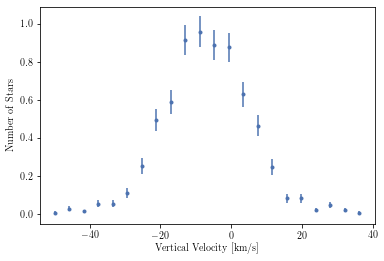

In [8]:
wmid, wnum, werr = wdata

plt.errorbar(wmid, wnum, yerr=werr, fmt='.')
plt.xlabel("Vertical Velocity [km/s]")
plt.ylabel("Number of Stars")
plt.show()

In [9]:
from hammer import vel

psi, locs, scales, labels, labs = generate_init("kin")
[(lb, l, t, l+s) for lb,  l, t,s in zip(labels, locs, theta, scales)]

[('$w_0$', -15.0, 0.0104, 0.0),
 ('$\\log \\sigma_w$', 0.0, 0.0277, 5.0),
 ('$q_{\\sigma,w}$', 0.0, 0.0073, 1.0),
 ('$\\log a$', -1.0, 0.0005, 1.0),
 ('$q_a$', 0.0, 0.0006, 1.0),
 ('$\\log \\Phi$', 0.0, 0.0018, 10.0)]

In [10]:
ndim = len(labs)
nwalker = 10*ndim
p0 = vel.generate_p0(nwalker, locs, scales)
indexes = list(range(ndim))
p0.shape

(60, 6)

In [11]:
from tqdm import tqdm
indexes = list(range(ndim))

for _ in tqdm(range(5)):
    chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
    labs, locs_normal, scales_normal = get_initial_position_normal(labs, "kin", chain=chain[1000:], indexes=indexes)
    p0 = vel.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
    chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
    p0 = chain[-1]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


In [12]:
chain = vel.mcmc(100_000, p0, wdata, locs, scales, parallel=True, verbose=True)
chain_thin = chain[::100]

6it [00:00, 46.12it/s]


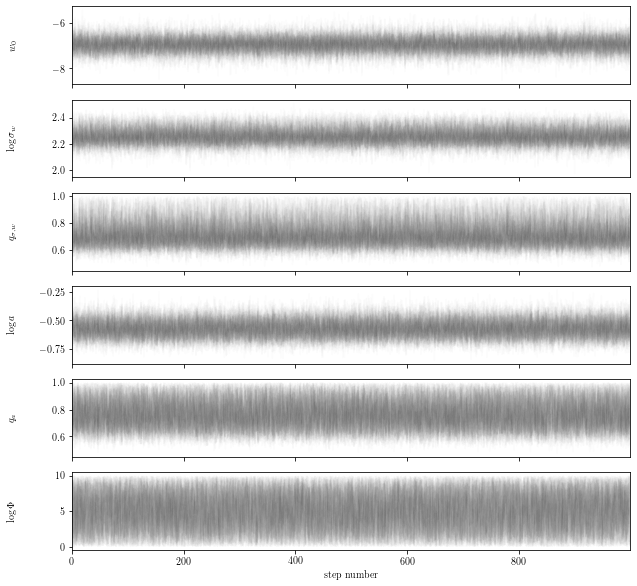

In [13]:
params = get_params(chain_thin, indexes, labs)

plot_chain(params, labels, alpha=0.01)

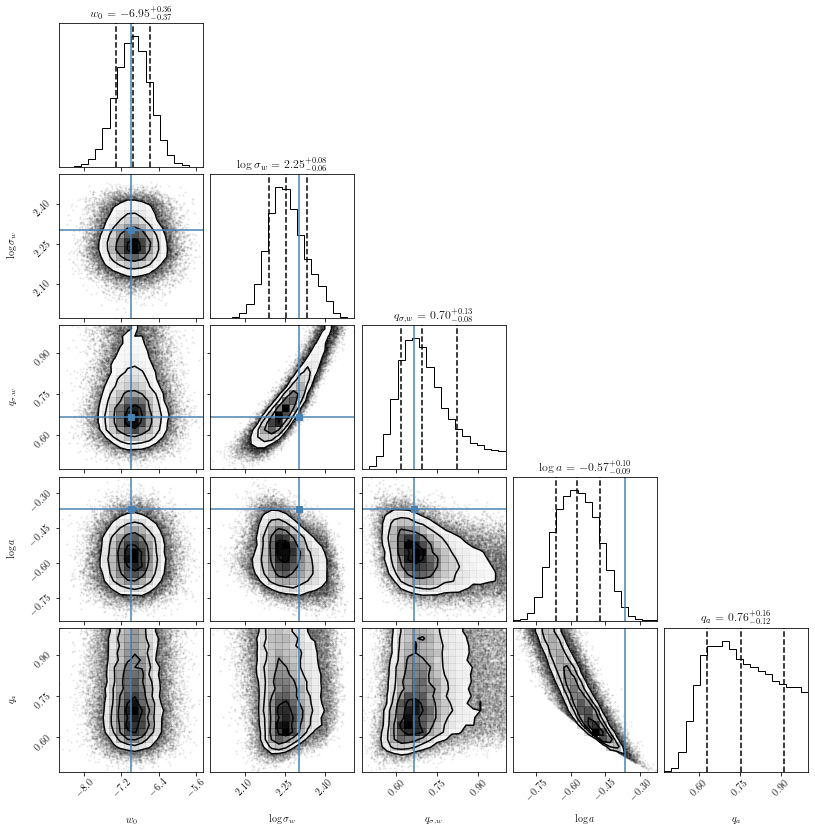

In [14]:
import corner
w0 = -7.
sigma1 = 10.
sigma2 = 15.
log_sigmaw = np.log(sigma1)
q_sigmaw = sigma1/sigma2
a1 = 0.9
a2 = 0.4
atot = a1+a2
a1 = a1/atot
a2 = a2/atot
log_a = np.log(a1)
q_a = a2/a1

flat_samples = chain_thin.reshape(-1, ndim)
fig = corner.corner(
  flat_samples[:,:-1], 
  labels=labels[:-1], 
  quantiles=[0.16, 0.5, 0.84], 
  show_titles=True,
  truths=[w0, log_sigmaw, q_sigmaw, log_a, q_a]
);

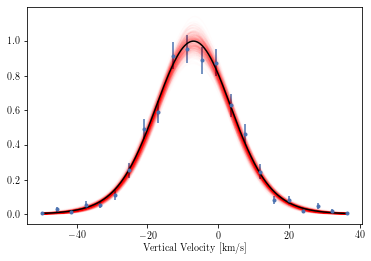

In [16]:
ws = np.linspace(wmid.min(), wmid.max(), 1000)

THETA = np.array([w0, log_sigmaw, q_sigmaw, log_a, q_a, 1])
# plot
plt.errorbar(wmid, wnum, yerr=werr, fmt='.', label="data")
for i in range(400):
    th = flat_samples[np.random.randint(len(flat_samples))]
    plt.plot(ws, vel.fw(ws, th), alpha=0.01, color='r')
plt.plot(ws, vel.fw(ws, THETA), color='k', label="fit")
plt.xlabel("Vertical Velocity [km/s]")
plt.show()

## potential space

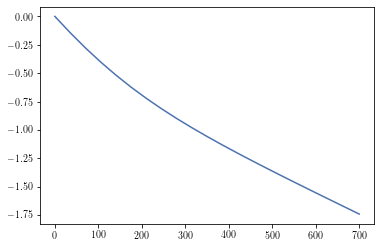

In [17]:
phi_max = 700
phis = np.linspace(0.001, phi_max, 21)
inds = np.random.randint(0, len(flat_samples), 5000)
log_sigmaw = flat_samples[inds[0], 1]
q_sigmaw = flat_samples[inds[0], 2]
log_a = flat_samples[inds[0], 3]
q_a = flat_samples[inds[0], 4]

sigmaw1 = np.exp(log_sigmaw)
sigmaw2 = sigmaw1 / q_sigmaw
a1 = np.exp(log_a)
a2 = a1 * q_a
atot = a1 + a2

nus = (a1*np.exp(-phis/sigmaw1**2) + a2*np.exp(-phis/sigmaw2**2))/atot

plt.plot(phis, np.log10(nus))
plt.show()

In [18]:
phis = np.linspace(0.001, phi_max, 1000)
N = len(flat_samples)
print(N)
log_zmod_phi = np.empty((N, len(phis)))
for i in tqdm(range(N)):
    th = flat_samples[i]
    log_sigmaw = th[1]
    q_sigmaw = th[2]
    log_a = th[3]
    q_a = th[4]
    sigmaw1 = np.exp(log_sigmaw)
    sigmaw2 = sigmaw1 / q_sigmaw
    a1 = np.exp(log_a)
    a2 = a1 * q_a
    atot = a1 + a2
    zmod_phi_i = (a1*np.exp(-phis/sigmaw1**2)+a2*np.exp(-phis/sigmaw2**2))/atot
    log_zmod_phi[i] = np.log(zmod_phi_i)
log_zmod_phi

60000


100%|██████████| 60000/60000 [00:04<00:00, 13157.90it/s]


array([[-9.66918160e-06, -6.78102567e-03, -1.35447187e-02, ...,
        -4.54271473e+00, -4.54652544e+00, -4.55033600e+00],
       [-8.46249368e-06, -5.93723098e-03, -1.18642051e-02, ...,
        -5.15628053e+00, -5.16094172e+00, -5.16560240e+00],
       [-8.34819057e-06, -5.85656659e-03, -1.17020764e-02, ...,
        -4.84209648e+00, -4.84640859e+00, -4.85072032e+00],
       ...,
       [-7.66043928e-06, -5.37507338e-03, -1.07419778e-02, ...,
        -5.09537051e+00, -5.10024141e+00, -5.10511190e+00],
       [-7.58150657e-06, -5.31970624e-03, -1.06313623e-02, ...,
        -5.07335277e+00, -5.07824188e+00, -5.08313067e+00],
       [-8.52244561e-06, -5.97923325e-03, -1.19480181e-02, ...,
        -5.17861040e+00, -5.18330687e+00, -5.18800288e+00]])

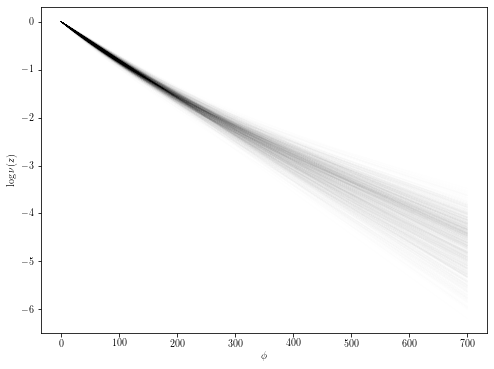

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(phis, log_zmod_phi[::60].T, 'k', alpha=0.005)
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\log \nu(z)$')
plt.show()

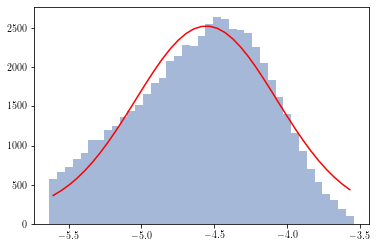

In [20]:
from scipy.stats import median_abs_deviation as mad_func
from scipy.optimize import curve_fit
from scipy.stats import norm

# def gaussian(x, mu, sigma1, sigma2, sigma3, a1, a2, a3):
#   return a1*norm.pdf(x, mu, sigma1)+a2*norm.pdf(x, mu, sigma2)+a3*norm.pdf(x, mu, sigma3)

def gaussian(x, mu, sigma1, sigma2, a1, a2):
  return a1*norm.pdf(x, mu, sigma1)+a2*norm.pdf(x, mu, sigma2)

phi_i = 900
index = np.argmin(np.abs(phis-phi_i))
log_zmod_phi_i = log_zmod_phi[:, index]
med = np.median(log_zmod_phi_i)
mad = mad_func(log_zmod_phi_i)
mask = np.abs(log_zmod_phi_i-med) < 3*mad
log_zmod_phi_i = log_zmod_phi_i[mask]

low = med-3*mad
high = med+3*mad
yedge = np.linspace(low, high, 40)
dy = yedge[1]-yedge[0]
ymid = (yedge[1:]+yedge[:-1])/2
ynum, _ = np.histogram(log_zmod_phi_i, bins=yedge)
# ynum
mask = ynum > 0
ynum = ynum[mask]
ymid = ymid[mask]

popt, _ = curve_fit(gaussian, ymid, ynum, p0=[-10, 5, 5, 1000, 1000])

# plot
plt.bar(ymid, ynum, width=dy, alpha=0.5)
plt.plot(ymid, gaussian(ymid, *popt), c="r")              

In [21]:
med = np.median(log_zmod_phi, axis=0)
mad = mad_func(log_zmod_phi, axis=0)
partition = 50
pred = np.empty((len(phis), 2, partition))
phi_mod = phis
for i, (log_zmod_phi_i, med_i, mad_i) in enumerate(zip(log_zmod_phi.T, med, tqdm(mad))):
    mask = np.abs(log_zmod_phi_i-med_i) < 3*mad_i
    log_zmod_phi_i = log_zmod_phi_i[mask]
    low = med_i-3*mad_i
    high = med_i+3*mad_i
    log_znum_edge = np.linspace(low, high, partition+1)
    dy = log_znum_edge[1]-log_znum_edge[0]
    log_znum_mod = (log_znum_edge[1:]+log_znum_edge[:-1])/2
    znum_weight, _ = np.histogram(log_zmod_phi_i, bins=log_znum_edge)
    total = znum_weight.sum()
    znum_weight = znum_weight/total
    pred_i = np.array([np.exp(log_znum_mod), znum_weight])
    pred[i] = pred_i

100%|█████████▉| 999/1000 [00:04<00:00, 214.37it/s]


In [22]:
np.save(join(zpath, 'PHI', 'pred.npy'), pred)

# Fit z

In [23]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob 
import vaex
from hammer import dm
root_dir = abspath(join('..', '..'))
root_data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)
from utils import (plot_corner, plot_chain, plot_fit, style, calculate_probs, get_params,
                   get_initial_position_normal, concat, get_data, generate_init)
style()

zpath = join(root_data_dir, 'MCMC-no', 'mock', 'data',  'z')
wpath = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
zpath, wpath

name = "Baryon"
baryon_dir = join(root_data_dir, name)
baryon_dir

# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [24]:
# #init dynamics
# rhob = df_baryon["rho"].to_numpy()  # Msun/pc^3
# sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
# rhob_e = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
# sigmaz_e = df_baryon["e_sigma_z"].to_numpy() # km/s
# rhob_init = {'mean_arr': rhob, 'sigma_arr': rhob_e}
# sigmaz_init = {'mean_arr': sigmaz, 'sigma_arr': sigmaz_e}
# rhoDM_init = {'low': -0.05, 'high': 0.1, 'value': 0.016, 'label': r'$\rho_{\textup{DM}}$', 'lab': 'rhoDM'}
# sigmaDD_init = {'low': 0., 'high': 30., 'value': 7., 'label': r'$\sigma_{\textup{DD}}$', 'lab': 'sigmaDD'}
# hDD_init = {'low': 1., 'high': 1000., 'value': 30., 'label': r'$h_{\textup{DD}}$', 'lab': 'hDD'}
# log_nu0_init = {'low': -1.5, 'high': 1.5, 'value': 0., 'label': r'$\log \nu_0$', 'lab': 'log_nu0'}
# R_init = {'mean': 3.4E-3, 'sigma': 0.6E-3, 'value': 3.4E-3, 'label': r'$R$', 'lab': 'R'}
# zsun_init = {'low': -150, 'high': 150, 'value': 0., 'label': r'$z_{\odot}$', 'lab': 'zsun'}
# # init kinematic
# w0_init = {'low': -15, 'high': 0., 'value': -7., 'label': r'$w_0$', 'lab': 'w0'}
# log_sigmaw_init = {'low': 0., 'high': 5., 'value': 2.4, 'label': r'$\log \sigma_w$', 'lab': 'log_sigmaw'}
# q_sigmaw_init = {'low': 0., 'high': 1., 'value': 0.5, 'label': r'$q_{\sigma,w}$', 'lab': 'q_sigmaw'}
# log_a_init = {'low': -1., 'high': 1., 'value': np.log(0.7), 'label': r'$\log a$', 'lab': 'log_a'}
# q_a_init = {'low': 0., 'high': 1., 'value': 0.5, 'label': r'$q_a$', 'lab': 'q_a'}
# log_phi_init = {'low': 0., 'high': 10., 'value': 2., 'label': r'$\log \Phi$', 'lab': 'log_phi'}

# init_kinematic = [w0_init, log_sigmaw_init, q_sigmaw_init, log_a_init, q_a_init, log_phi_init]
# init_DM = [rhob_init, sigmaz_init, rhoDM_init, log_nu0_init, R_init, zsun_init]
# init_DDDM = [rhob_init, sigmaz_init, rhoDM_init, sigmaDD_init, hDD_init, log_nu0_init, R_init, zsun_init]
# init_no = [rhob_init, sigmaz_init, log_nu0_init, R_init, zsun_init]

# init_dict = {
#     "kin": init_kinematic,
#     "DM": init_DM,
#     "DDDM": init_DDDM,
#     "no": init_no,
# }

# def flatten_array(arr):
#     flattened = []
#     for item in arr:
#         if isinstance(item, np.ndarray):
#             flattened.extend(flatten_array(item))
#         else:
#             flattened.append(item)
#     return np.array(flattened)

# def generate_init(ini):
#     init = init_dict[ini]
#     # print(init)
#     theta = np.array([])
#     locs = np.array([])
#     scales = np.array([])
#     labels = np.array([])
#     labs = np.array([])
#     for init_i in init:
#         if 'mean_arr' in init_i.keys():
#             locs = np.append(locs, init_i['mean_arr'])
#             scales = np.append(scales, init_i['sigma_arr'])
#             theta = np.append(theta, init_i['mean_arr'])
#             continue
#         elif 'low' in init_i.keys():
#             locs = np.append(locs, init_i['low'])
#             scales = np.append(scales, init_i['high'] - init_i['low'])
#             theta = np.append(theta, init_i['value'])
#         elif 'mean' in init_i.keys():
#             locs = np.append(locs, init_i['mean'])
#             scales = np.append(scales, init_i['sigma'])
#             theta = np.append(theta, init_i['value'])
#         else:
#             raise ValueError("malformed init")
#         labels = np.append(labels, init_i['label'])
#         labs = np.append(labs, init_i['lab'])
#     return theta, flatten_array(locs), flatten_array(scales), labels, labs

In [25]:
index = 5
zdata, wdata = get_data(zpath, wpath, index)
zdata[0]

array([-713.2249826 , -646.15486329, -579.08474398, -512.01462466,
       -444.94450535, -377.87438604, -310.80426673, -243.73414741,
       -176.6640281 , -109.59390879,  -42.52378948,   24.54632984,
         91.61644915,  158.68656846,  225.75668777,  292.82680709,
        359.8969264 ,  426.96704571,  494.03716503,  561.10728434,
        628.17740365,  695.24752296])

## load pred

In [27]:
pred = np.load(join(zpath, 'PHI', 'pred.npy'))
phi_max = 700
phis = np.linspace(0.001, phi_max, 1000)
kin = (phis, pred)
# kin

In [28]:
theta, locs, scales, labels, labs = generate_init("DM")

ndim = len(locs)+24
nwalker = 10*ndim
p0 = dm.generate_p0(nwalker, locs, scales)
indexes = [12] + list(range(len(locs)))
[(loc, th, scale+loc) for loc, th, scale in zip(locs, theta[24:], scales)]

[(-0.05, 0.016, 0.10000000000000002),
 (-1.5, 0.0, 1.5),
 (0.0034, 0.0034, 0.004),
 (-150.0, 0.0, 150.0)]

In [29]:
indexes = [12] + list(range(24, 24+len(locs)))
indexes, labs, labels

([12, 24, 25, 26, 27],
 array(['rhob', 'rhoDM', 'log_nu0', 'R', 'zsun'], dtype='<U32'),
 array(['$\\rho_{b}$', '$\\rho_{\\textup{DM}}$', '$\\log \\nu_0$', '$R$',
        '$z_{\\odot}$'], dtype='<U32'))

In [30]:
dm.log_prob(theta, zdata, kin, locs, scales, dz=1.)

(63.08661695025105, 74.14249656084975)

In [31]:
dm.log_prob_par(p0, zdata, kin, locs, scales, dz=1.)

array([[ 5.47093653e+01, -8.04354685e+03, -7.98883749e+03],
       [ 5.58151563e+01, -2.07725161e+03, -2.02143646e+03],
       [ 5.44693966e+01, -5.15228425e+02, -4.60759028e+02],
       [ 5.10303879e+01, -9.00312185e+02, -8.49281798e+02],
       [ 4.95159478e+01, -2.03133325e+03, -1.98181730e+03],
       [ 5.23560784e+01, -4.32386743e+04, -4.31863182e+04],
       [ 4.91050021e+01, -1.20124149e+03, -1.15213648e+03],
       [ 5.05788914e+01, -1.29789630e+04, -1.29283841e+04],
       [ 5.31078959e+01, -8.13952579e+02, -7.60844683e+02],
       [ 5.05680770e+01, -1.14121965e+05, -1.14071397e+05],
       [ 5.44217227e+01, -1.52132555e+03, -1.46690382e+03],
       [ 4.88585179e+01, -2.36384674e+02, -1.87526156e+02],
       [ 5.12270989e+01, -5.21901100e+03, -5.16778390e+03],
       [ 5.61085031e+01, -1.38352129e+04, -1.37791044e+04],
       [ 4.58281278e+01, -3.39703369e+03, -3.35120556e+03],
       [ 5.73182311e+01, -6.11613131e+02, -5.54294900e+02],
       [ 5.21460913e+01, -8.63037448e+02

In [32]:
chain = dm.mcmc(100, nwalker, zdata, kin, p0, locs, scales, dz=1., parallel=True, verbose=True)

5it [00:00,  9.14it/s]


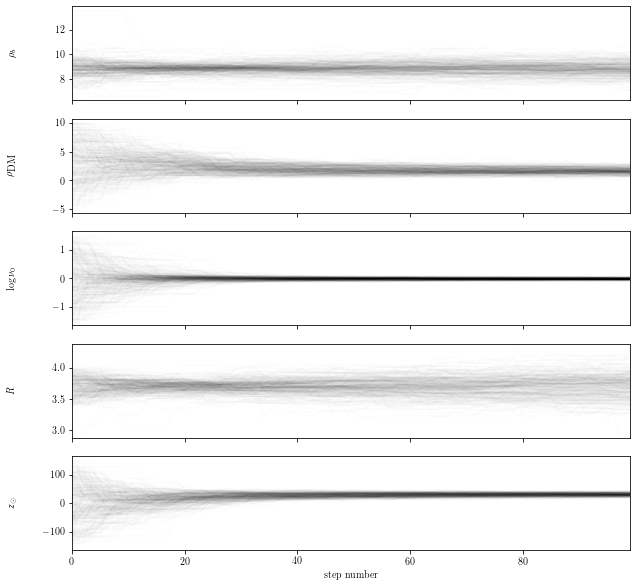

In [33]:
params = get_params(chain, indexes, labs)

plot_chain(params, labels, alpha=0.01)

In [36]:
p0 = chain[-1]
chain = dm.mcmc(1000, nwalker, zdata, kin, p0, locs, scales, dz=1., parallel=True, verbose=True)

5it [00:00, 10.87it/s]


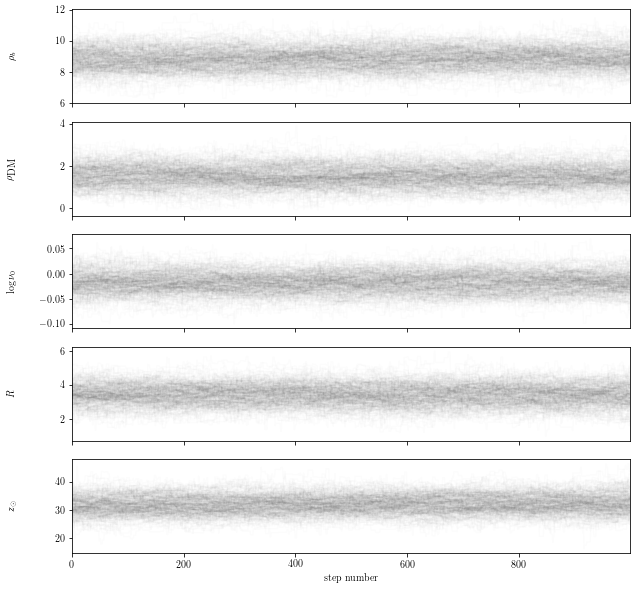

In [37]:
params = get_params(chain, indexes, labs)

plot_chain(params, labels, alpha=0.01)

In [39]:
from tqdm import tqdm

flat_samples = chain.reshape(-1, ndim)

zn = []
for _ in tqdm(range(5000)):
    th = flat_samples[np.random.randint(len(flat_samples))]
    zsun = th[27]
    log_nu0 = th[25]
    nu0 = np.exp(log_nu0)
    zt = dm.phi_invers(phis, th, 500., dz=0.5)
    zrel = zt + zsun
    for i, zt_i in enumerate(zrel):
        pred_i = pred[i]
        znum_mod, znum_weight = pred_i
        sgn = np.random.choice([-1, 1])
        zt_i = zt_i*sgn - zsun
        zn.append((zt_i, [nu0*znum_mod, znum_weight]))

  1%|          | 34/5000 [00:01<02:16, 36.35it/s]

100%|██████████| 5000/5000 [02:20<00:00, 35.63it/s]


In [42]:
from scipy.optimize import curve_fit
from scipy.stats import norm

zmid, znum, zerr = zdata

z_edge = np.linspace(zmid.min(), zmid.max(), 100)
z_mid = (z_edge[1:]+z_edge[:-1])/2
ynum = np.empty((2, len(z_edge)-1))
for i, (z0, z1) in enumerate(zip(tqdm(z_edge[:-1]), z_edge[1:])):
    ys = np.array([zn_i[1][0] for zn_i in zn if (zn_i[0] <z1) and (zn_i[0] >z0)]).flatten()
    weights = np.array([zn_i[1][1] for zn_i in zn if (zn_i[0] <z1) and (zn_i[0] >z0)]).flatten()
    yn, yedge = np.histogram(ys, bins=50, weights=weights, density=True)
    if any(np.isnan(yn)):
        ynum[:, i] = [0, 1]    
        continue
    ymid = (yedge[1:]+yedge[:-1])/2
    popt, _ = curve_fit(norm.pdf, ymid, yn, p0=[1, 1], maxfev=2000)
    ynum[:, i] = popt

  0%|          | 0/99 [00:00<?, ?it/s]

/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
 45%|████▌     | 45/99 [00:52<01:06,  1.23s/it]

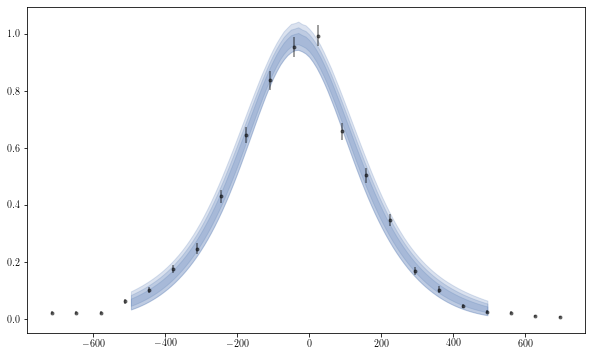

In [41]:
ymid = ynum[0]
yerr = ynum[1]
mask = ymid > 0
ymid = ymid[mask]
yerr = yerr[mask]

plt.figure(figsize=(10,6))
plt.errorbar(zmid, znum, yerr=zerr, fmt='.', color='k', alpha=0.5)
plt.fill_between(z_mid[mask], ymid-yerr, ymid+yerr, alpha=0.2, color='C0')
# plt.fill_between(-z_mid[mask], ymid-yerr, ymid+yerr, alpha=0.2, color='C0')
plt.fill_between(z_mid[mask], ymid-2*yerr, ymid+2*yerr, alpha=0.2, color='C0')
# plt.fill_between(-z_mid[mask], ymid-2*yerr, ymid+2*yerr, alpha=0.2, color='C0')
plt.fill_between(z_mid[mask], ymid-2*yerr, ymid+3*yerr, alpha=0.2, color='C0')
# plt.fill_between(-z_mid[mask], ymid-2*yerr, ymid+3*yerr, alpha=0.2, color='C0')
# plt.yscale('log')
plt.show()

labs

In [8]:
locs_raw = dict(
    rhoDM=-0.05,
    log_nu0=-1,
    R=3.4E-3,
    zsun=-100,
    w0=-15,
    log_sigmaw=np.log(1),
    q_sigmaw=0.,
    log_a=np.log(0.01),
    q_a=0.,
)

scales_raw = dict(
    rhoDM=0.15,
    log_nu0=3,
    R=0.6E-3,
    zsun=200,
    w0=15,
    log_sigmaw=np.log(50)-locs_raw['log_sigmaw'],
    q_sigmaw=1.,
    log_a=np.log(100)-locs_raw['log_a'],
    q_a=1.0
)

keys = list(locs_raw.keys())
locs = np.array(list(locs_raw.values()))
scales = np.array(list(scales_raw.values()))

[(k, loc, th, s+loc) for k, loc, th, s in zip(keys, locs, theta[24:], scales)]

[('rhoDM', -0.05, 0.016, 0.09999999999999999),
 ('log_nu0', -1.0, 0.0, 2.0),
 ('R', 0.0034, 0.0034, 0.004),
 ('zsun', -100.0, 30.0, 100.0),
 ('w0', -15.0, -7.0, 0.0),
 ('log_sigmaw', 0.0, 1.6094379124341003, 3.912023005428146),
 ('q_sigmaw', 0.0, 0.5, 1.0),
 ('log_a', -4.605170185988091, -0.10536051565782628, 4.605170185988093),
 ('q_a', 0.0, 0.11111111111111112, 1.0)]

In [9]:
ndim = len(locs_raw)+24
nwalkers = 10*ndim
ndim, nwalkers

(33, 330)

In [10]:
p0 = dm.generate_p0(nwalkers, locs, scales)
p0.shape

(330, 33)

In [11]:
for p in p0:
    print(dm.log_prob(p, zdata, wdata, locs, scales))

(41.64152132936716, -27369.560433694605)
(47.67291486782712, -72510.54041654775)
(41.12401105651686, -27169.114531550862)
(44.76829348073811, -33484.02964360766)
(40.90127130653721, -758689538.945552)
(50.00250132770124, -4147015920.605182)
(48.432447861057206, -767017.8848955468)
(39.32745829757512, -1810700.1804887378)
(50.751879007914184, -66642067.682198785)
(48.547558854893296, -1386.1960059981527)
(42.626686367403295, -4165.496978517)
(47.71690802538392, -5856.005502739634)
(44.331402904631446, -76155.79552251668)
(50.55127991817994, -7506.834105975935)
(46.37078788074773, -2491934.2826729887)
(42.46052069848465, -3298.6900892303825)
(37.81709923427948, -2836.9314488945884)
(44.05151116403588, -3353.5500201687955)
(43.07791927210032, -4773.406938282935)
(46.63071531196418, -69917920.3771412)
(48.44477581664158, -134398.86241514873)
(45.92207976311632, -3190.3850433504917)
(47.43771503382117, -2649.0427587551776)
(47.218894084690525, -32279.897808634752)
(42.40951145234707, -27196

In [12]:
p0_flat = p0.reshape(-1, ndim)
dm.log_prob_par(p0_flat, zdata, wdata, locs, scales)

array([[ 4.16415213e+01, -2.74112020e+04, -2.73695604e+04],
       [ 4.76729149e+01, -7.25582133e+04, -7.25105404e+04],
       [ 4.11240111e+01, -2.72102385e+04, -2.71691145e+04],
       [ 4.47682935e+01, -3.35287979e+04, -3.34840296e+04],
       [ 4.09012713e+01, -7.58689580e+08, -7.58689539e+08],
       [ 5.00025013e+01, -4.14701597e+09, -4.14701592e+09],
       [ 4.84324479e+01, -7.67066317e+05, -7.67017885e+05],
       [ 3.93274583e+01, -1.81073951e+06, -1.81070018e+06],
       [ 5.07518790e+01, -6.66421184e+07, -6.66420677e+07],
       [ 4.85475589e+01, -1.43474356e+03, -1.38619601e+03],
       [ 4.26266864e+01, -4.20812366e+03, -4.16549698e+03],
       [ 4.77169080e+01, -5.90372241e+03, -5.85600550e+03],
       [ 4.43314029e+01, -7.62001269e+04, -7.61557955e+04],
       [ 5.05512799e+01, -7.55738539e+03, -7.50683411e+03],
       [ 4.63707879e+01, -2.49198065e+06, -2.49193428e+06],
       [ 4.24605207e+01, -3.34115061e+03, -3.29869009e+03],
       [ 3.78170992e+01, -2.87474855e+03

(33,)


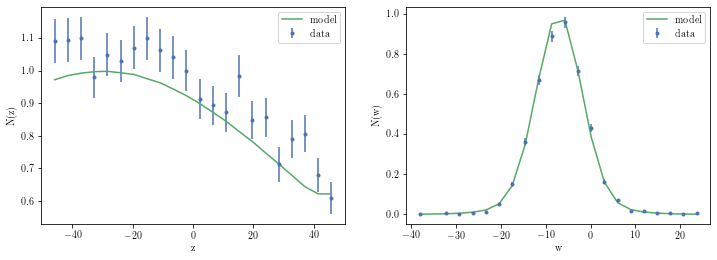

(57.199650418000715, 141.72350424040576)

In [13]:
print(theta.shape)
zmod = dm.fz(zmid, theta)
wmod = dm.fw(wmid, theta)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', label='data')
ax[0].plot(zmid, zmod, label='model')
ax[0].set_xlabel('z')
ax[0].set_ylabel('N(z)')
ax[0].legend()
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', label='data')
ax[1].plot(wmid, wmod, label='model')
ax[1].set_xlabel('w')
ax[1].set_ylabel('N(w)')
ax[1].legend()
plt.show()
dm.log_prob(theta, zdata, wdata, locs, scales)

In [19]:
time0 = time()
for i in range(5):
    print("\t",i)
    t0 = time()
    chain = dm.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
    print(time() - t0, "s")
    burn = 300
    keys, locs_normal, scales_normal = get_initial_position_normal(keys, chain[burn:], np.arange(24, 24+len(keys)))
    p0 = dm.generate_p0(nwalkers, locs_normal, scales_normal, norm=True)
    t0 = time()
    chain = dm.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
    print(time() - t0, "s")
    p0 = chain[-1]
print("total", time() - time0, "s")

	 0
12.386143922805786 s
12.276070356369019 s
	 1
12.175869941711426 s
12.381832361221313 s
	 2
12.31183910369873 s
12.400343894958496 s
	 3
12.226510524749756 s
12.41160249710083 s
	 4
12.27902889251709 s
12.553856372833252 s
total 123.56651639938354 s


In [20]:
# test calculate_probs
calculate_probs(dm, chain, ndim, zdata, wdata, locs, scales, batch=100)

array([[ 48.0732265 ,  76.29392977, 124.36715627],
       [ 48.35478716, 100.5806173 , 148.93540446],
       [ 49.06463217,  32.03440237,  81.09903454],
       ...,
       [ 42.47447185, 106.58657712, 149.06104897],
       [ 44.48441991, 106.01214988, 150.49656979],
       [ 46.96360788, 110.36698841, 157.33059629]])

10it [00:01,  7.21it/s]


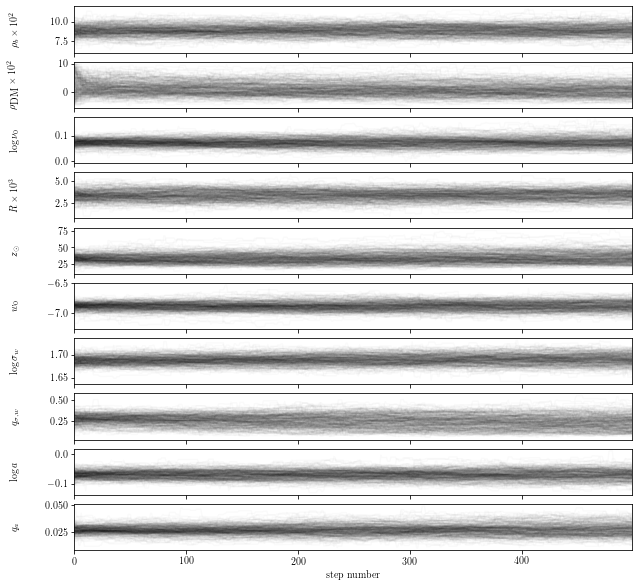

In [21]:
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\log \nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]

params = get_params(chain, indexes, labs)
plot_chain(params, labels, figsize=(10,10), alpha=0.02)

### long

In [22]:
p0_next = chain[-1]
t0 = time()
chain = dm.mcmc(2000, nwalkers, p0_next, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
print(time() - t0, "s")
chain.shape

49.028559923172 s


(2000, 330, 33)

10it [00:01,  7.55it/s]


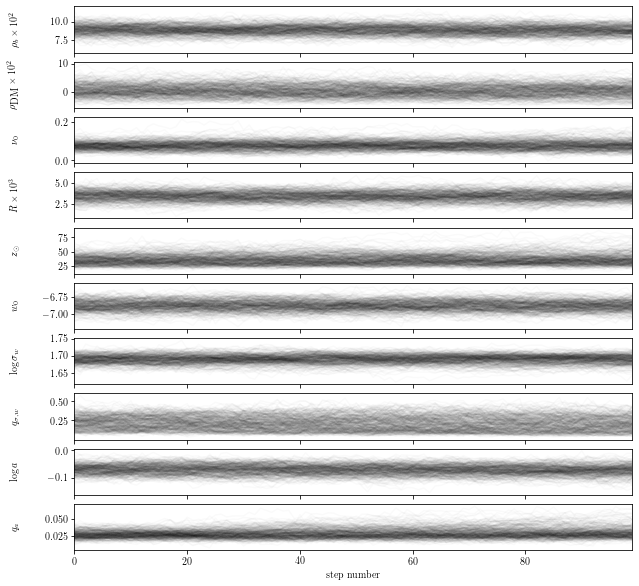

In [23]:
thin = 20
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]

params = get_params(chain[::thin], indexes, labs)
plot_chain(params, labels, figsize=(10,10), alpha=0.02)

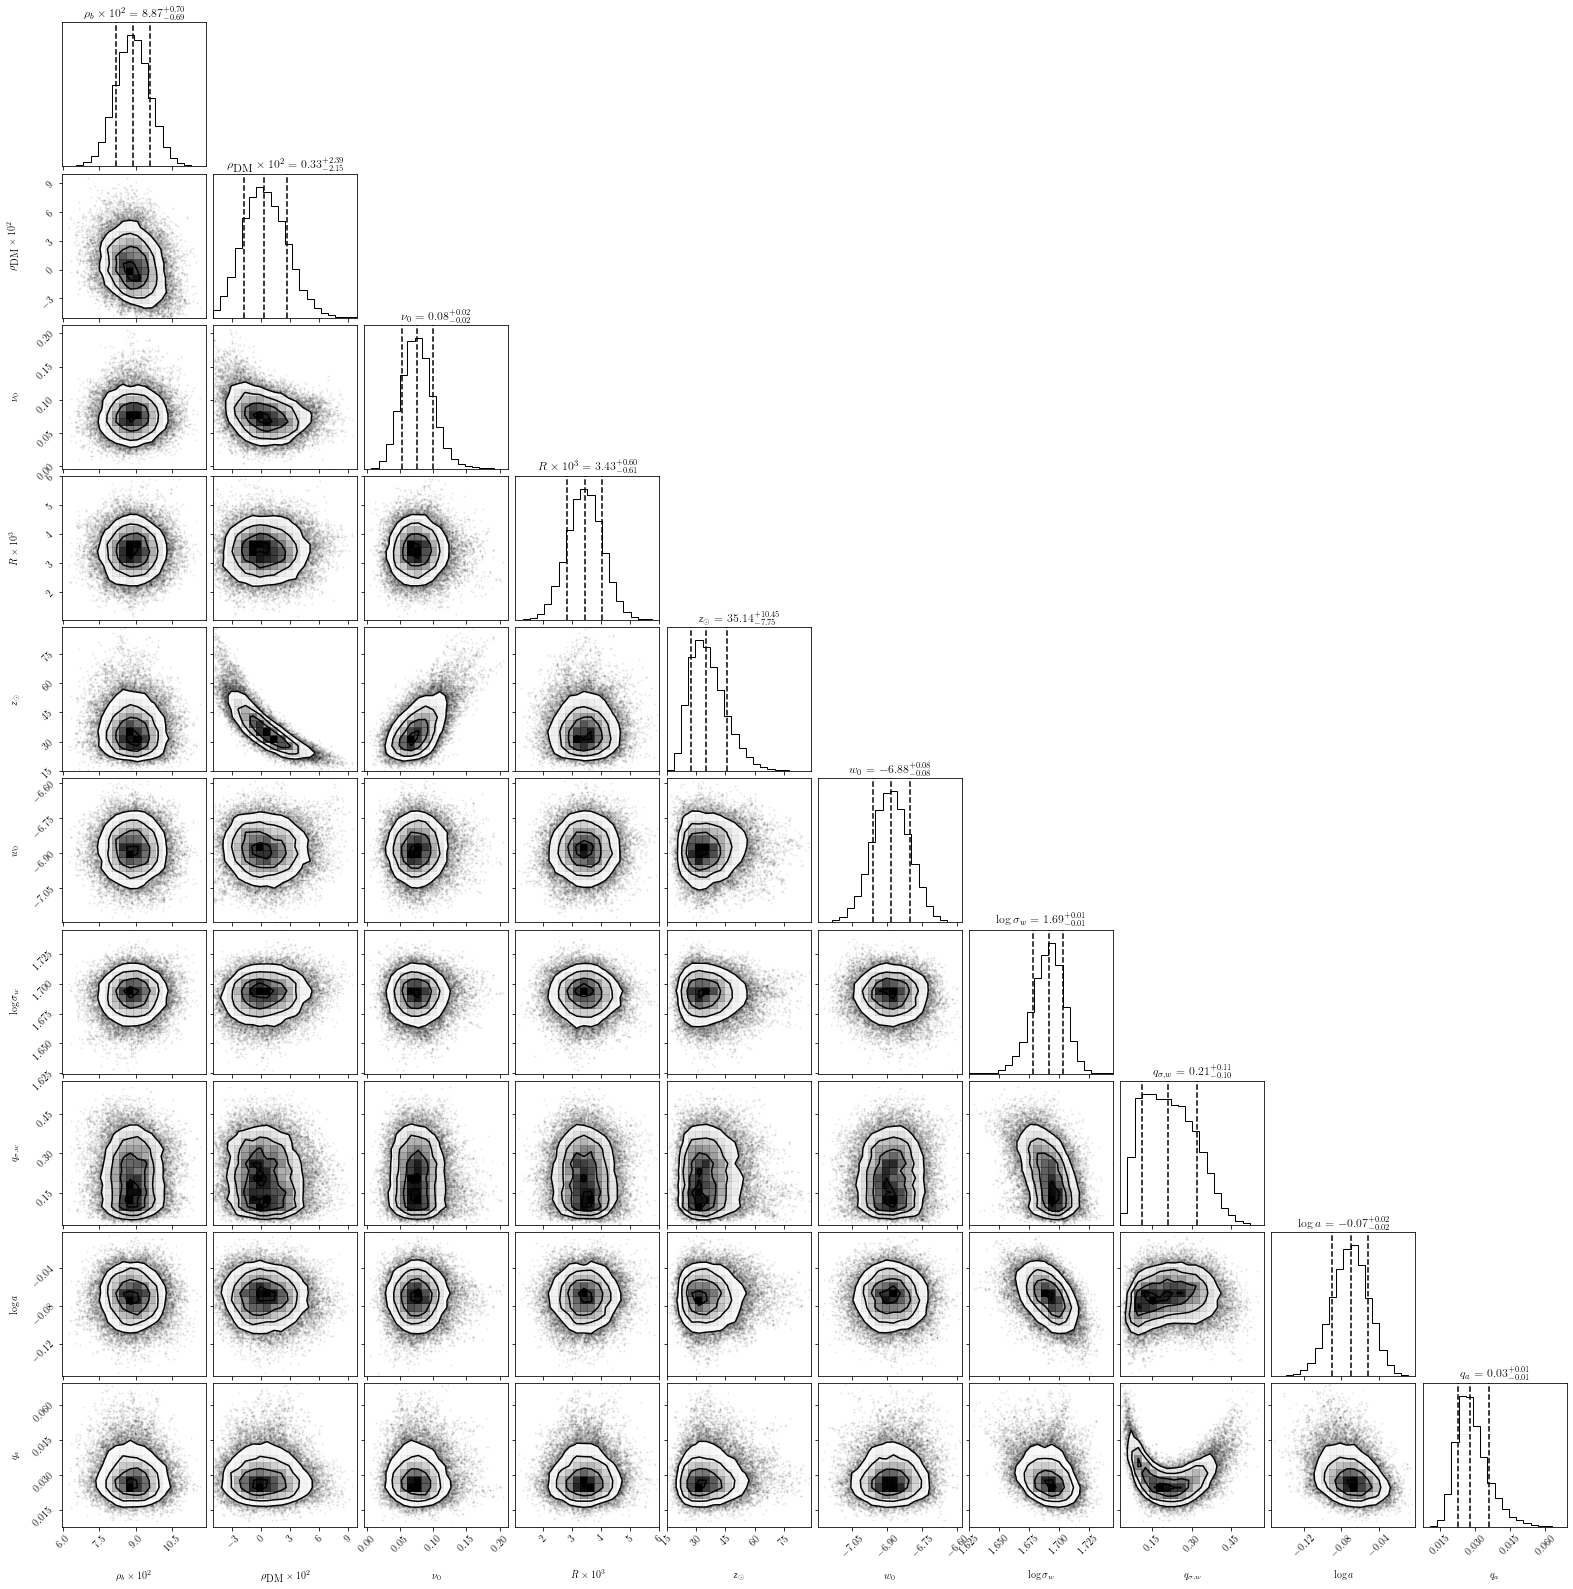

In [24]:
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]
chain_thin = chain[::thin]

params = get_params(chain_thin, indexes, labs)
plot_corner(params, labels)

(33000, 33)


100%|██████████| 5000/5000 [00:03<00:00, 1579.34it/s]


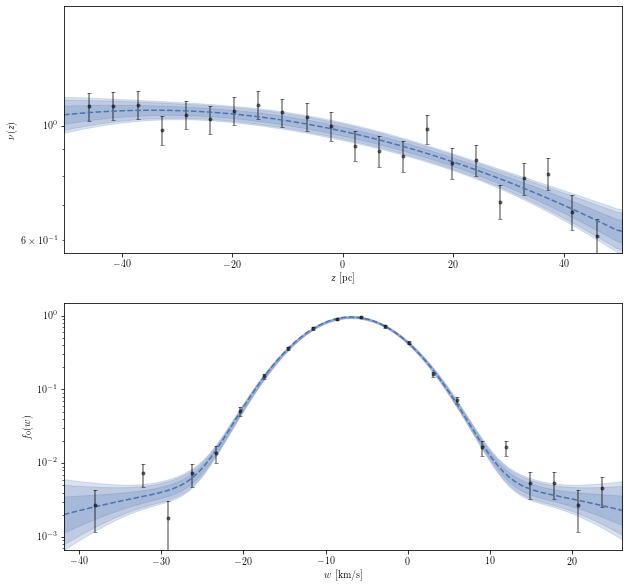

In [25]:
plot_fit(dm, zdata, wdata, chain_thin, ndim, n=5_000)

In [26]:
probs = calculate_probs(dm, chain_thin, ndim, zdata, wdata, locs, scales)

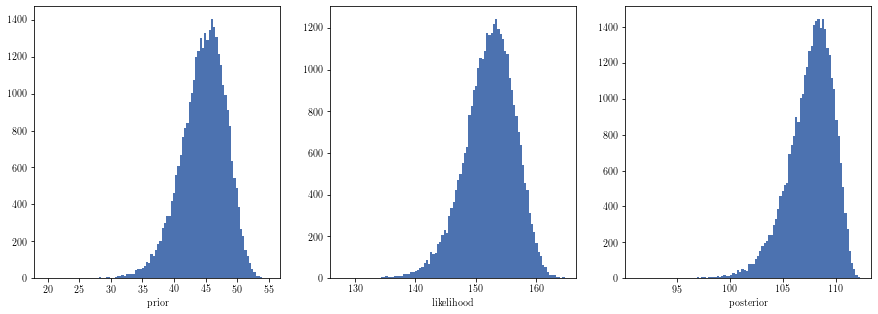

164.65889761422915

In [27]:
prior = probs[:, 0]
likelihood = probs[:, 2]
posterior = probs[:, 1]
# plot histogram of probabilities
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(prior, bins=100)
axes[0].set_xlabel('prior')
axes[1].hist(likelihood, bins=100)
axes[1].set_xlabel('likelihood')
axes[2].hist(posterior, bins=100)
axes[2].set_xlabel('posterior')
plt.show()
likelihood.max()

# Script

do mcmc for

* same $N$, different $z$
* same $z$, different $N$

Each 'running' contains
1. generate_init: initial position for walkers.
    * this is done by the experiment above.
2. run_mcmc: run true mcmc for 10_000 steps.
3. plot trace: plot trace plot for preliminary mcmc.
4. plot corner: plot corner plot for the long run.
5. plot fit: fitting plot for vertical density and vertical dispersion.
6. calculate bic & aic: calculate bic and aic for the long run.

All of these functionalities are implemented in `mcmc.py` at `utils`.

Just run the `program.py` at `script`.
To automate the process for all data, run `run_program.py` at `script`.